In [1]:

from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# 1.) function for reading data and formatting

def read_file(file_name): 
    data_list  = []
    with open(file_name, 'r') as f: 
        for line in f: 
            line = line.strip() 
            label = ' '.join(line[1:line.find("]")].strip().split())
            text = line[line.find("]")+1:].strip()
            data_list.append([label, text])
    return data_list 

In [0]:
# file path

file_name = "../content/psychExp.txt"
psychExp_txt = read_file(file_name)

In [4]:
print('Total no. of instances: {}'.format(len(psychExp_txt)))

Total no. of instances: 7480


In [0]:
# method for converting labels from one hot to classes

def convert_label(item, name): 
    items = list(map(float, item.split()))
    label = ""
    for idx in range(len(items)): 
        if items[idx] == 1: 
            label += name[idx] + " "
    
    return label.strip()

In [0]:
# classes

emotions = ["joy", 'fear', "anger", "sadness", "disgust", "shame", "guilt"]

In [0]:
X_all = []
y_all = []
for label, text in psychExp_txt:
    X_all.append(text.lower())
    y_all.append(convert_label(label, emotions))

In [8]:
# Data processing

from string import punctuation
print('punctuations to be removed: {}'.format(punctuation))

X_all_pro = []
for text in X_all:
    all_text = ''.join([c for c in text if c not in punctuation])
    X_all_pro.append(all_text)

punctuations to be removed: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [0]:
# Tokenize — Create Vocab to Int mapping dictionary

from collections import Counter
all_text2 = ' '.join(X_all_pro)

# create a list of words
words = all_text2.split()

# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

In [135]:

sorted_words.insert(0,('',11000))
print(len(sorted_words))

9341


In [0]:
# vocab to integer mapping dictionary with starting index 1

vocab_to_int = {w:i for i, (w,c) in enumerate(sorted_words)}

In [0]:
target_vocab = []
for i, (w,c) in enumerate(sorted_words):
  target_vocab.append(w)

In [17]:

!pip3 install bcolz


     |████████████████████████████████| 1.5MB 3.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz


In [0]:
import bcolz
import numpy as np
import pickle

In [0]:

words = []
idx = 0
word2idx = {}
glove_path = "../content/gdrive/My Drive/"
store_dir = "../content"
vectors = bcolz.carray(np.zeros(1), rootdir=f'{store_dir}/6B.300.dat', mode='w')

with open(f'{glove_path}/glove.6B.300d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    
vectors = bcolz.carray(vectors[1:].reshape((400000, 300)), rootdir=f'{store_dir}/6B.300.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'{store_dir}/6B.300_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{store_dir}/6B.300_idx.pkl', 'wb'))


In [0]:

store_dir = "../content"
vectors = bcolz.open(f'{store_dir}/6B.300.dat')[:]
words = pickle.load(open(f'{store_dir}/6B.300_words.pkl', 'rb'))
word2idx = pickle.load(open(f'{store_dir}/6B.300_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [0]:
# glove["happy"]

In [0]:

matrix_len = len(target_vocab)
weights_matrix = np.zeros((matrix_len, 300))
words_found = 0
emb_dim = 300

for i, word in enumerate(target_vocab):
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))

In [23]:
weights_matrix.shape


(9340, 300)

In [0]:
#self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)

In [25]:
# encoading the words

X_all_int = []
for text in X_all_pro:
    r = [vocab_to_int[w] for w in text.split()]
    X_all_int.append(r)
    
print (X_all_int[0:3])

[[112, 2, 572, 9, 952, 10, 161, 256, 35, 13, 27, 169, 6, 540, 8, 27, 11, 15, 169, 14, 3, 150, 35], [8, 1, 7, 414, 10, 3, 772, 192], [8, 1, 7, 326, 50, 33, 189, 177, 9, 347, 114, 63, 7, 3, 4683, 1363, 9, 12, 41, 7, 326, 18, 1462, 4684, 6, 283, 550, 43, 606, 4685, 4, 314, 12, 2282]]


In [0]:
# for convering labels from classes to class index
def label_to_int(label_text):
    emotions_dict = {"joy":0, "fear":1, "anger":2, "sadness":3, "disgust":4, "shame":5, "guilt":6}
    label_int = []
    for label in label_text:
        label_int.append(emotions_dict[label])
    return label_int
  
  
labels = label_to_int(y_all)

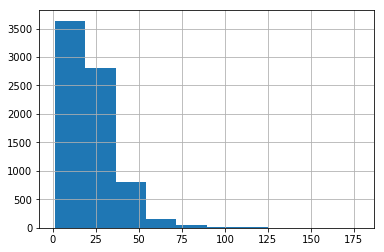

count    7480.000000
mean       22.160160
std        14.654072
min         1.000000
25%        12.000000
50%        19.000000
75%        30.000000
max       178.000000
dtype: float64

In [28]:
# analysing the text data lenghth

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
text_len = [len(x) for x in X_all_int]
pd.Series(text_len).hist()
plt.show()
pd.Series(text_len).describe()

In [0]:
# padding the data for having same dimention
import numpy as np

def pad_features(text_int, seq_length):
    ''' Return features of text_ints, where each text is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(text_int), seq_length), dtype = int)
    
    for i, text in enumerate(text_int):
        text_len = len(text)
        
        if text_len <= seq_length:
            zeroes = list(np.zeros(seq_length-text_len))
            new = zeroes+text
        elif text_len > seq_length:
            new = text[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [0]:
seq_length = 64 # length after padding 
X_all_pad = pad_features(X_all_int, seq_length)

In [31]:
print('length of X_all_pad: {}'.format(len(X_all_pad)))
print('length of labels: {}'.format(len(labels)))

# converting labels from list to numpy.nparray

print('data type of labels before convesion: {}'.format(type(labels)))
labels = np.array(labels)
print('data type of labels after convesion: {}'.format(type(labels)))

length of X_all_pad: 7480
length of labels: 7480
data type of labels before convesion: <class 'list'>
data type of labels after convesion: <class 'numpy.ndarray'>


In [32]:
# train (80%), validation (10%) ,test data (10%) split

len_X_all = len(X_all_pad)


split_frac = 0.8

train_x = X_all_pad[0:int(split_frac*len_X_all)+16]
train_y = labels[0:int(split_frac*len_X_all)+16]

remaining_x = X_all_pad[int(split_frac*len_X_all)-4:]
remaining_y = labels[int(split_frac*len_X_all)-4:]

test_x = remaining_x[0:int(len(remaining_x)*0.5)]
test_y = remaining_y[0:int(len(remaining_y)*0.5)]

valid_x = remaining_x[int(len(remaining_x)*0.5):]
valid_y = remaining_y[int(len(remaining_y)*0.5):]

print(type(train_x),type(np.array(train_y)))

print("train data size: ",train_x.shape)
print("remaining data size: ",remaining_x.shape)
print("valid data size: ",valid_x.shape)
print("test data size: ",test_x.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
train data size:  (6000, 64)
remaining data size:  (1500, 64)
valid data size:  (750, 64)
test data size:  (750, 64)


In [0]:
# Data loading and batch formation

import torch
from torch.utils.data import DataLoader, TensorDataset

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# Shuffeling the data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [34]:
# obtain one batch of training data

dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 64])
Sample input: 
 tensor([[   0,    0,    0,  ...,    1,   45,  199],
        [   0,    0,    0,  ...,    7,  288, 1699],
        [   0,    0,    0,  ...,    5,  297,  108],
        ...,
        [   0,    0,    0,  ...,  130,   18,   72],
        [   0,    0,    0,  ...,    4,  100,   26],
        [   0,    0,    0,  ...,  181,    1,  325]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 1, 0, 2, 1, 5, 4, 6, 5, 3, 0, 4, 1, 3, 6, 5, 1, 0, 5, 3, 6, 0, 3, 6,
        1, 0, 1, 2, 1, 1, 4, 3, 4, 5, 2, 2, 2, 5, 6, 3, 1, 4, 4, 2, 3, 4, 2, 1,
        6, 0])


In [0]:
def create_emb_layer(weights_matrix, non_trainable=True):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    #emb_layer.load_state_dict({'weight': weights_matrix})
    emb_layer.weight.data.copy_(torch.from_numpy(weights_matrix))
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [0]:
from logger import Logger

logger = Logger('../content/logs')

# Building the model #

In [0]:
# building the model

import torch.nn as nn
import torch.nn.functional as F

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self,weights_matrix, output_size,num_filters,window_sizes , drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size

        self.num_filters = num_filters
        
        self.window_sizes = window_sizes
        
        
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        
        
        
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, [window_size, embedding_dim], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        
        self.fc = nn.Linear(num_filters * len(window_sizes), output_size)
        
        self.relu = nn.ReLU()
        

    def forward(self, x ):
        """
        Perform a forward pass of our model on some input and hidden state.
        """

        # embeddings and cnn
        x = self.embedding(x)
        x = torch.unsqueeze(x, 1)       # [B, C, T, E] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))        # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)            # [B, F, window]

        # FC
        x = x.view(x.size(0), -1)       # [B, F * window]
        logits = self.fc(x)             # [B, class]

        # Prediction
        probs = F.softmax(logits)       # [B, class]
        classes = torch.max(probs, 1)[1]# [B]

        return probs, classes
    


## Initializing the model ##

In [39]:
# Initiating the hyperparams

output_size = 7
num_filters = 128
window_sizes= (3, 4, 5)



# device to train on 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Initiating model and model weights

net = SentimentLSTM(weights_matrix, output_size,num_filters,window_sizes)
net.to(device)
print(net)


cuda:0
SentimentLSTM(
  (embedding): Embedding(9340, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 128, kernel_size=[3, 300], stride=(1, 1), padding=(2, 0))
    (1): Conv2d(1, 128, kernel_size=[4, 300], stride=(1, 1), padding=(3, 0))
    (2): Conv2d(1, 128, kernel_size=[5, 300], stride=(1, 1), padding=(4, 0))
  )
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=384, out_features=7, bias=True)
  (relu): ReLU()
)


# Training the model #

In [41]:
import time
import os
import copy

# Traing the model

since = time.time()

best_model_wts = copy.deepcopy(net.state_dict())
best_acc = 0.0



lr=0.001 # learning rate

# Initiating optimizer

import torch.optim as optim
optimizer = optim.Adam(net.parameters(),lr=lr)

# definig loss function

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

# training params

epochs = 100
counter = 0
print_every = 130
clip=5 # gradient clipping to prevent from gradients exploading 

train_on_gpu = True if torch.cuda.is_available() else False
loss = 0

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

# train for some number of epochs


for e in range(epochs):
  

    
    # for calculating train accuracy every epoch
    total = 0
    correct = 0
    
    net.train()
    
    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.to(device), labels.to(device)



        # Converting accumulated gradients to zero at starting of every epoch
        net.zero_grad()
      
      
        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        probs, classes = net(inputs.to(device))
        
        # getting the index of output tensors with max values
        
    
        # for calculating accuracy
        total += labels.size(0)
        correct += (classes == labels).sum().item() # comparing predictions to true label
        
        
        # calculate the loss and perform backprop
        loss = criterion(probs, labels)
        loss.backward()
        
        # clip_grad_norm helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        
        _, argmax = torch.max(probs, 1)
        accuracy = (labels == argmax.squeeze()).float().mean()

        # loss stats
        if counter % print_every == 0:
          
            info = { 'loss': loss.item(), 'accuracy': accuracy.item() }

            for tag, value in info.items():
                logger.scalar_summary(tag, value, counter+1)
                    
                # 2. Log values and gradients of the parameters (histogram summary)
            for tag, value in net.named_parameters():
                tag = tag.replace('.', '/')
                logger.histo_summary(tag, value.data.cpu().numpy(), counter+1)
                if value.grad is not None:
                    logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), counter+1)
          
            
            total_val = 0
            correct_val = 0
            
            val_losses = [] # for tracking loss
            net.eval()
            for inputs, labels in valid_loader:


                if(train_on_gpu):
                    inputs, labels = inputs.to(device), labels.to(device)

                inputs = inputs.type(torch.LongTensor)
                probs, classes = net(inputs.to(device))
                

    
                # for calculating accuracy
                total_val += labels.size(0)
                correct_val += (classes == labels).sum().item() # comparing predictions to true label

                val_loss = criterion(probs, labels)

                val_losses.append(val_loss.item())
              
            net.train()
              
            val_acc = (correct_val / total_val) * 100

            # deep copy the model
            if (val_acc > best_acc):
                best_acc = val_acc
                print("saving model .....")
                best_model_wts = copy.deepcopy(net.state_dict())
            
            
            
            
            print("-"*10)
            print("")
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Step: {}".format(counter),
                  "Loss: {:.4f}".format(loss.item()),
                  "Val Loss: {:.4f}".format(np.mean(val_losses)))
            
            
            print("Train accuracy: {:.2f}".format((correct / total) * 100), "Val accuracy: {:.2f}".format(val_acc))
            print("")
            print("-"*10)
            
            
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


saving model .....
----------

Epoch: 2/100 Step: 130 Loss: 1.4764 Val Loss: 1.6464
Train accuracy: 69.60 Val accuracy: 53.07

----------
saving model .....
----------

Epoch: 3/100 Step: 260 Loss: 1.4754 Val Loss: 1.6318
Train accuracy: 72.80 Val accuracy: 54.27

----------
----------

Epoch: 4/100 Step: 390 Loss: 1.4177 Val Loss: 1.6303
Train accuracy: 79.60 Val accuracy: 52.80

----------
saving model .....
----------

Epoch: 5/100 Step: 520 Loss: 1.4150 Val Loss: 1.6157
Train accuracy: 86.60 Val accuracy: 54.53

----------
saving model .....
----------

Epoch: 6/100 Step: 650 Loss: 1.2882 Val Loss: 1.6030
Train accuracy: 88.48 Val accuracy: 57.47

----------
----------

Epoch: 7/100 Step: 780 Loss: 1.3309 Val Loss: 1.6118
Train accuracy: 89.63 Val accuracy: 54.80

----------
----------

Epoch: 8/100 Step: 910 Loss: 1.3094 Val Loss: 1.6128
Train accuracy: 90.86 Val accuracy: 54.80

----------
----------

Epoch: 9/100 Step: 1040 Loss: 1.2097 Val Loss: 1.6063
Train accuracy: 91.50 Val

In [44]:
net.load_state_dict(best_model_wts)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Testing the model on test dataset ##

In [123]:
test_losses = [] # for tracking loss
import numpy as np

y_true = []

y_probs = []

y_pred = []


total = 0
correct = 0
net.eval()

# iterate over test data
for inputs, labels in test_loader:



    if(train_on_gpu):
        inputs, labels = inputs.to(device), labels.to(device)
        
    
    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    probs, classes = net(inputs.to(device))
    
    y_true += labels.cpu().numpy().tolist()
    y_probs += classes.cpu().numpy().tolist()
    y_pred += probs.cpu().detach().tolist()

    # for calculating accuracy
    total += labels.size(0)
    correct += (classes == labels).sum().item() # comparing predictions to true label

    
    test_loss = criterion(probs, labels)
    test_losses.append(test_loss.item())
    
print("Test loss: {:.3f}".format(np.mean(test_losses)))    
print('Accuracy of the network on the test data : {:.3f} %'.format((correct / total) * 100))


Test loss: 1.493
Accuracy of the network on the test data : 66.800 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## functions for analysis of model ##

In [0]:

import sklearn.metrics as metrics

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm =  metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the da
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [0]:
! pip3 install scikit-plot
import scikitplot as skplt

In [0]:
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df, fpr, tpr

# Analysis of Model #

             precision    recall  f1-score  support   pred       AUC
0             0.774194  0.864865  0.817021    111.0  124.0  0.964359
1             0.797980  0.724771  0.759615    109.0   99.0  0.938256
2             0.628571  0.600000  0.613953    110.0  105.0  0.898082
3             0.657658  0.682243  0.669725    107.0  111.0  0.912676
4             0.634409  0.561905  0.595960    105.0   93.0  0.869900
5             0.558333  0.638095  0.595556    105.0  120.0  0.898915
6             0.622449  0.592233  0.606965    103.0   98.0  0.914962
avg / total   0.669037  0.668000  0.667079    750.0  750.0  0.914642
Confusion matrix, without normalization
Confusion matrix, without normalization


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


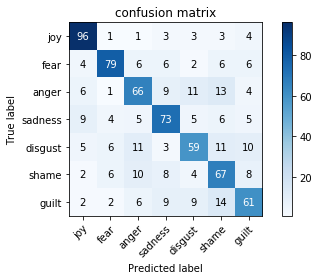

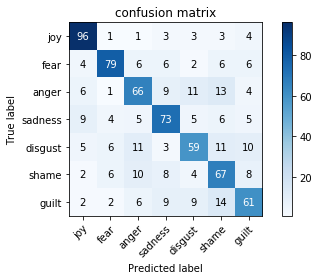

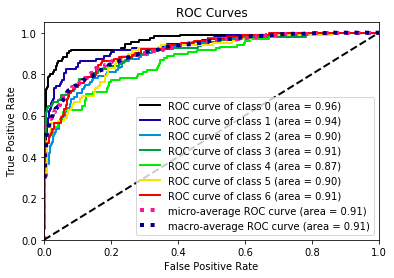

In [133]:
y_true = np.array(y_true)

y_probs = np.array(y_probs)

y_pred = np.array(y_pred)


report_with_auc , fpr , tpr = class_report(y_true=y_true, y_pred=y_probs, y_score=y_pred)

print(report_with_auc)

plot_confusion_matrix(y_true, y_probs, classes=emotions, normalize=False, title='confusion matrix')

plot_confusion_matrix(y_true, y_probs, classes=emotions, normalize=False, title='confusion matrix')

skplt.metrics.plot_roc_curve(y_true, y_pred)
plt.show()

## Testing model on custom string ##

In [46]:
# testing on custom dataset

from string import punctuation

# for tranforming the string into tokens

def tokenize_text(test_text):
    test_text = test_text.lower() # lowercase
    
    # get rid of punctuation
    test_text = ''.join([c for c in test_text if c not in punctuation])

    # splitting the lines into words for tokenization
    test_words = test_text.split()

    # tokenizing the text
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words])

    return test_ints
  
# test string
test_text = "I am very angry and sad !! :)"


def predict(net, test_text, sequence_length):
    
    net.eval()
    
    # tokenize text
    test_ints = tokenize_text(test_text)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convering the array to tensor to pass into the model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0) # number of strings to test

    
    if(train_on_gpu):
        feature_tensor = feature_tensor.to(device)
    
    # get the output from the model
    probs, classes = net(feature_tensor)
    print(probs.cpu().detach().numpy())
    print(emotions)


    print("{} --> {}".format(test_text, emotions[classes.cpu().numpy()[0]]))

    
predict(net, test_text, sequence_length=64)

[[3.4538571e-05 2.2265426e-04 1.2759455e-02 9.8604196e-01 6.5532414e-04
  1.8914632e-04 9.6951670e-05]]
['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt']
I am very angry and sad !! :) --> sadness


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
#torch.save(net.state_dict(), 'model_sentiment_analysis_GRU_Pretrainied_v1.pt')